In [1]:
import pandas as pd
from tbh.paths import DATA_FOLDER

fertility_data = pd.read_csv(DATA_FOLDER / 'un_fertility_rates_KIR.csv',index_col=0)
normalised_fertility_data = fertility_data.div(fertility_data.sum(axis=1), axis=0)

In [2]:
def get_agegap_prob(normalised_fertility_data, age_gap, birth_year):
    """
    Retrieve the probability of a given parent-child age gap for a specific birth year.

    Parameters:
        normalised_fertility_data (pd.DataFrame): Fertility probabilities indexed by birth year, columns are mothers' ages.
        age_gap (int): Age difference between parent and child.
        birth_year (int): Year of birth of the child.

    Returns:
        float: Probability corresponding to the age gap and birth year, or 0.0 if out of range.
    """

    # Ensure birth_year is within the data range, if not, clamp it to the nearest available year
    earliest_year, latest_year = normalised_fertility_data.index.min(), normalised_fertility_data.index.max()
    birth_year = min(max(birth_year, earliest_year), latest_year)

    # Return 0.0 if age_gap is less than youngest age in the data or greater than oldest age
    youngest_age, oldest_age = normalised_fertility_data.columns.astype(int).min(), normalised_fertility_data.columns.astype(int).max()
    if age_gap < youngest_age or age_gap > oldest_age:
        return 0.0
    else:
        return normalised_fertility_data[str(age_gap)].loc[birth_year]

get_agegap_prob(normalised_fertility_data, age_gap=30, birth_year=2000)

0.047657945369281425

In [3]:
def get_single_age_population(iso_3, max_age=120):
    pop_data = pd.read_csv(DATA_FOLDER / "un_population.csv")
    pop_data = pop_data[pop_data["ISO3_code"] == iso_3][["Time", "AgeGrp", "PopTotal"]]

    rows = []
    for _, r in pop_data.iterrows():
        year = r["Time"]
        pop = r["PopTotal"]
        agegrp = r["AgeGrp"]

        if agegrp.endswith("+"):   # normally "100+"
            a0 = int(agegrp[:-1]) 
            a1 = max_age
            assert a1 >= a0
        else:
            a0, a1 = map(int, agegrp.split("-"))
            
        n = a1 - a0 + 1
        for age in range(a0, a1 + 1):
            rows.append({
                "Time": year,
                "Age": age,
                "Pop": pop / n
            })

    return pd.DataFrame(rows)

single_age_pop_df = get_single_age_population(iso_3="KIR")

In [4]:

def get_relative_age_weight(age, lower_bound, upper_bound, single_age_pop_df, year):
    assert age >= lower_bound and age <= upper_bound       
    earliest_year, latest_year = single_age_pop_df['Time'].min(), single_age_pop_df['Time'].max()
    year = min(max(year, earliest_year), latest_year)

    subset_df = single_age_pop_df[(single_age_pop_df["Time"] == year) & (single_age_pop_df["Age"] >= lower_bound) & (single_age_pop_df["Age"] <= upper_bound)] 
    age_pop = subset_df[subset_df["Age"] == age]["Pop"].iloc[0]
    total_pop = subset_df["Pop"].sum()  

    return age_pop / total_pop

get_relative_age_weight(age=12, lower_bound=11, upper_bound=13, single_age_pop_df=single_age_pop_df, year=2000)


0.33333333333333337

single_age_df

In [5]:
def get_pc_agegap_weight(normalised_fertility_data, single_age_pop_df, age_groups, i, j, time, max_age=120):

    """
    Calculate the probability of a parent-child age gap given age groups and time.
    """
    # Determine the lower and upper bounds of the age groups
    lb_i, lb_j = int(age_groups[i]), int(age_groups[j])
    ub_i = int(age_groups[i+1]) - 1 if i < len(age_groups) - 1 else max_age
    ub_j = int(age_groups[j+1]) - 1 if j < len(age_groups) - 1 else max_age
    # 150 was chosen as an arbitrary upper limit for age.
    
    get_prob_pc_agegap = 0.
    for age_i in range(lb_i, ub_i + 1):
        i_weight = get_relative_age_weight(age_i, lb_i, ub_i + 1, single_age_pop_df, time)
        for age_j in range(lb_j, ub_j + 1):
            j_weight = get_relative_age_weight(age_j, lb_j, ub_j + 1, single_age_pop_df, time)  
            age_gap = abs(age_i - age_j)
            child_age = min(age_i, age_j)
            get_prob_pc_agegap += i_weight * j_weight * get_agegap_prob(normalised_fertility_data, age_gap, int(time - child_age))
    
    return get_prob_pc_agegap

age_groups = ["0", "3", "5", "10", "15", "18", "40", "65"]

get_pc_agegap_weight(normalised_fertility_data, single_age_pop_df, age_groups=age_groups, i=7, j=7, time=2000)

0.0022082927837491057

In [6]:
import numpy as np

def build_contact_matrix(normalised_fertility_data, single_age_pop_df, age_groups, pop_sizes:dict, a_spread, pc_strength, time):
    
    # Convert age group labels to integers
    age_lb = np.array([int(a) for a in age_groups])
    n_groups = len(age_lb)

    # Representative ages (midpoints); last group is open-ended "A+": represented by A + 10
    mid = [0.5 * (age_lb[i] + age_lb[i + 1] - 1) for i in range(n_groups - 1)] + [age_lb[-1] + 10.] 

    # Build symmetric per-pair contact matrix S, representing contact rate per pair of individuals
    S = np.zeros((n_groups, n_groups))
    for i in range(n_groups):
        for j in range(i, n_groups):
            age_diff = abs(mid[i] - mid[j])

            # Assortative mixing
            assortative = np.exp(-age_diff / a_spread)

            # Parent–child mixing
            parent_child = pc_strength * get_pc_agegap_weight(normalised_fertility_data, single_age_pop_df, age_groups, i, j, time)
            S[i, j] = assortative + parent_child
            if i != j:
                S[j, i] = S[i, j]

    # Convert to asymmetric matrix C, representing number of contacts per individual
    C = S * np.array([pop_sizes[age] for age in age_groups])[:, None]

    # Rescale C so its spectral radius is 1
    eigvals = np.linalg.eigvals(C)
    spectral_radius = max(abs(eigvals))
    normalised_C = C / spectral_radius

    return S, normalised_C

In [7]:
import matplotlib.pyplot as plt
def plot_contact_matrix(M, age_groups, title, cmap="viridis"):
    """
    Plot a contact matrix as a heatmap with ticks aligned to cell centres.
    """
    n = len(age_groups)

    fig, ax = plt.subplots(figsize=(7, 6))

    im = ax.imshow(
        M,
        origin="upper",
        cmap=cmap,
        aspect="auto",
        interpolation="none"
    )

    # Major ticks at cell centres
    age_lb = [int(a) for a in age_groups]
    labels = (
        [f"{age_lb[i]}-{age_lb[i+1] - 1}" for i in range(len(age_lb) - 1)]
        + [f"{age_lb[-1]}+"]
    )

    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Move x-axis to the top
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.tick_params(axis="x", top=True, bottom=False)

    # Set axis limits to match matrix extent exactly
    ax.set_xlim(-0.5, n - 0.5)
    ax.set_ylim(n - 0.5, -0.5)

    # Draw gridlines on cell boundaries
    ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
    ax.grid(which="minor", color="white", linestyle="-", linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    ax.set_xlabel("Contacting individual age group (j)")
    ax.set_ylabel("Contacted individual age group (i)")
    ax.set_title(title)

    plt.setp(ax.get_xticklabels(), rotation=20, ha="right")

    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Contact rate", rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

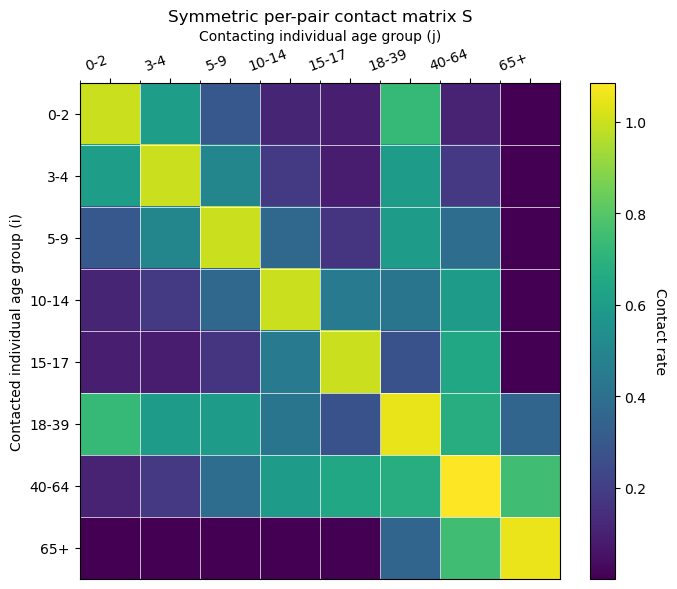

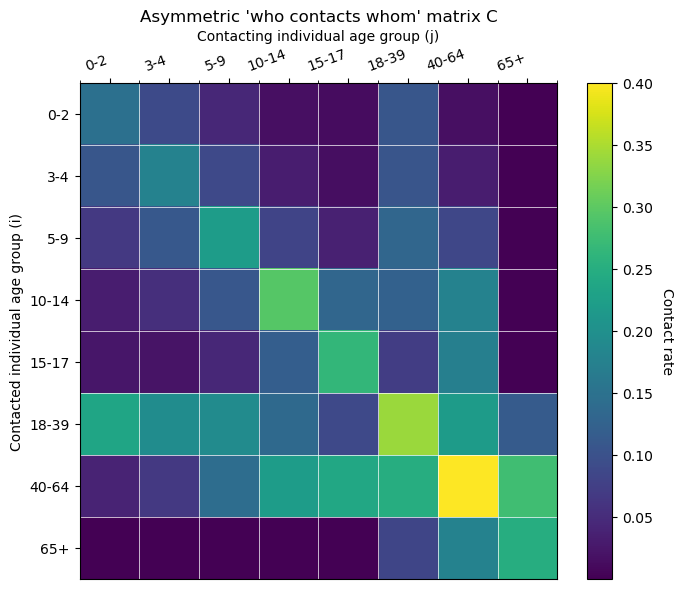

In [12]:
age_groups = ["0", "3", "5", "10", "15", "18", "40", "65"]
pop_sizes = {
    "0": 1000,
    "3": 1200,
    "5": 1500,
    "10": 2000,
    "15": 1800,
    "18": 2200,
    "40": 2500,
    "65": 1600
}
S, C = build_contact_matrix(normalised_fertility_data, single_age_pop_df, age_groups, pop_sizes, a_spread=5, pc_strength=25., time=2000)

plot_contact_matrix(
    S,
    age_groups,
    title="Symmetric per-pair contact matrix S"
)

plot_contact_matrix(
    C,
    age_groups,
    title="Asymmetric 'who contacts whom' matrix C"
)